In [1]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
from pandas.api.types import CategoricalDtype

import sklearn
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [2]:
import gc
gc.collect()

31

In [3]:
os.chdir("/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data")
print(os.getcwd())

/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data


In [4]:
# Read in Treatment Episode Data Set data
teds18 = pd.read_csv('tedsa_puf_2018.csv')

In [5]:
teds18.columns

Index(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
       'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
       'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
       'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'REGION', 'IDU', 'ALCDRUG'],
      dtype='object')

In [6]:
# Subset the data to just the 0/1 drug flag variables
flags = teds18.filter(regex='FLG$', axis = 1)

In [7]:
# Sum the flag variables to calculate the number of drugs recorded for each individual
NUMSUBS = flags.sum(axis=1)

In [8]:
# Concatenate flag variables back into the 2015-17 data
teds_wflgs = pd.concat([teds18, NUMSUBS], axis = 1)
teds_wflgs.rename(columns={0:'NUMSUBS'}, inplace = True)

In [9]:
# Remove rows where the first substance was "None"
teds_sm_temp = teds_wflgs[teds_wflgs.SUB1 != 1]
# Remove rows where number of prior treatments is NA (target variable)
teds_sm1 = teds_sm_temp[teds_sm_temp.NOPRIOR != -9]

In [10]:
# Select subset of columns
teds_sm = teds_sm1.loc[:,['CASEID','ADMYR','AGE','GENDER','RACE','ETHNIC','EDUC','EMPLOY','VET','LIVARAG',\
                          'STFIPS','CBSA2010','DIVISION','REGION','SERVICES','PSOURCE','NOPRIOR','ARRESTS','ROUTE1','FRSTUSE1','FREQ1', \
                          'ROUTE2','FRSTUSE2', 'FREQ2','ROUTE3','FRSTUSE3','FREQ3','NUMSUBS','METHUSE','ALCFLG','PSYPROB', \
                          'COKEFLG','MARFLG','HERFLG','METHFLG','OPSYNFLG','PCPFLG','HALLFLG','MTHAMFLG','AMPHFLG','STIMFLG', \
                          'BENZFLG','TRNQFLG','BARBFLG','SEDHPFLG','INHFLG','OTCFLG','OTHERFLG']]

In [12]:
# Recode age group variable
def age_groups(series):
    if series == 1:
        return '12_14_years'
    elif series == 2:
        return '15_17_years'
    elif series == 3:
        return '18_20_years'
    elif series == 4:
        return '21_24_years'
    elif series == 5:
        return '25_29_years'
    elif series == 6:
        return '30_34_years'
    elif series == 7:
        return '35_39_years'
    elif series == 8:
        return '40_44_years'
    elif series == 9:
        return '45_49_years'
    elif series == 10:
        return '50_54_years'
    elif series == 11:
        return '55_64_years'
    elif series == 12:
        return '65_plus_years'
    
teds_sm1.loc[:, 'age_group'] = teds_sm1.AGE.apply(age_groups)

# Change variable to an ordered factor
teds_sm1.loc[:, 'age_group'] = pd.Categorical(teds_sm1['age_group'], categories = ['12_14_years', '15_17_years', '18_20_years',
                                                                                   '21_24_years', '25_29_years', '30_34_years',
                                                                                   '35_39_years', '40_44_years', '45_49_years',
                                                                                   '50_54_years', '55_64_years', '65_plus_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'age_group'], sort = True)
teds_sm1.loc[:, 'age_group'] = labels

In [13]:
# Recode gender variable
def gen_rc(series):
    if series == 1:
        return 0
    elif series == 2:
        return 1
    
teds_sm1.loc[:, 'gender'] = teds_sm1.GENDER.apply(gen_rc)

In [14]:
# Recode methadone variable
def methadone_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'methadone_use'] = teds_sm1.METHUSE.apply(methadone_rc)

In [15]:
def educ_rc(series):
    if series == 1:
        return 'No_Schooling'
    elif series == 2:
        return 'Grades_9_to_11'
    elif series == 3:
        return 'Grades_12_or_GED'
    elif series == 4:
        return 'College_1_to_3_years'
    elif series == 5:
        return 'College_4_or_more_years'

teds_sm1.loc[:, 'educ'] = teds_sm1.EDUC.apply(educ_rc)

# Change variable to an ordered factor
teds_sm1.loc[:, 'educ'] = pd.Categorical(teds_sm1['educ'], categories = ['No_Schooling', 'Grades_9_to_11', 'Grades_12_or_GED',
                                                                         'College_1_to_3_years', 'College_4_or_more_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'educ'], sort = True)
teds_sm1.loc[:, 'educ'] = labels

In [16]:
# Record race variable
def race_rc(series):
    if series == 1:
        return 'Alaska_Native'
    elif series == 2:
        return 'American_Indian'
    elif series == 3 or series == 9:
        return 'Hawaiian_Pacific_Islander'
    elif series == 4:
        return 'Black'
    elif series == 5:
        return 'White'
    elif series == 6:
        return 'Asian'
    elif series == 7:
        return 'Other_race'
    elif series == 8:
        return 'Two_or_more_races'
    
teds_sm1.loc[:, 'race'] = teds_sm1.RACE.apply(race_rc)

In [17]:
# Recode ethnicity variable
def ethnic_rc(series):
    if (series >= 1 or series <= 3) or series == 5:
        return 1
    elif series == 4:
        return 0
    
teds_sm1.loc[:, 'ethnic'] = teds_sm1.ETHNIC.apply(ethnic_rc)

In [18]:
# Recode service setting variable
def servseta_rc(series):
    if series == 1 or series == 2:
        return 'Detox'
    elif series >= 3 and series <= 5:
        return 'Rehab_Residential'
    elif series >= 6 and series <= 8:
        return 'Ambulatory'

teds_sm1.loc[:, 'services'] = teds_sm1.SERVICES.apply(servseta_rc)

In [19]:
# Recode marital status variable
def marstat_rc(series):
    if series == 1:
        return 'Never_Married'
    elif series == 2:
        return 'Married'
    elif series == 3:
        return 'Separated'
    elif series == 4:
        return 'Divorced_or_Widowed'

teds_sm1.loc[:, 'marstat'] = teds_sm1.MARSTAT.apply(marstat_rc)

In [20]:
# Recode employment status variable
def employ_rc(series):
    if series == 1:
        return 'Full_time'
    elif series == 2:
        return 'Part_time'
    elif series == 3:
        return 'Unemployed'
    elif series == 4:
        return 'Not_in_labor_force'
    
teds_sm1.loc[:, 'employ'] = teds_sm1.EMPLOY.apply(employ_rc)

In [21]:
# Recode veteran variable
def vet_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'vet'] = teds_sm1.VET.apply(vet_rc)

In [22]:
# Recode living arrangement variable
def livarag_rc(series):
    if series == 1:
        return 'Homeless'
    elif series == 2:
        return 'Dependent_Living'
    elif series == 3:
        return 'Independent_Living'

teds_sm1.loc[:, 'livarag'] = teds_sm1.LIVARAG.apply(livarag_rc)

In [23]:
# Recode arrests variable
def arrests_rc(series):
    if series == 0:
        return 'None'
    elif series == 1:
        return 'Once'
    elif series == 2:
        return 'Two_or_more_times'
    
teds_sm1.loc[:, 'arrests'] = teds_sm1.ARRESTS.apply(arrests_rc)

# Change variable to an ordered factor variable
teds_sm1.loc[:, 'arrests'] = pd.Categorical(teds_sm1['arrests'], categories = ['None', 'Once',
                                                                              '2 or more times'],
                                           ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'arrests'], sort = True)
teds_sm1.loc[:, 'arrests'] = labels

In [24]:
# Recode division variable
def division_rc(series):
    if series == 0:
        return 'US_Territories'
    elif series == 1:
        return 'New_England'
    elif series == 2:
        return 'Mid_Atlantic'
    elif series == 3:
        return 'East_North_Central'
    elif series == 4:
        return 'West_North_Central'
    elif series == 5:
        return 'South_Atlantic'
    elif series == 6:
        return 'East_South_Central'
    elif series == 7:
        return 'West_South_Central'
    elif series == 8:
        return 'Mountain'
    elif series == 9:
        return 'Pacific'
    
teds_sm1.loc[:, 'division'] = teds_sm1.DIVISION.apply(division_rc)

In [25]:
# Recode referral source variable
def psource_rc(series):
    if series == 1:
        return 'Self_referral'
    elif series == 2:
        return 'Alcohol_Drug_Care_Professional'
    elif series == 3:
        return 'Other_Health_Care_Professional'
    elif series == 4:
        return 'School_Referral'
    elif series == 5:
        return 'Employer_Referral'
    elif series == 6:
        return 'Community_Referral'
    elif series == 7:
        return 'Court_Referral'
    
teds_sm1.loc[:, 'psource'] = teds_sm1.PSOURCE.apply(psource_rc)

In [26]:
# Recode number of prior treatment encounters
def noprior_rc(series):
    if series == 0:
        return 0
    elif series >= 1:
        return 1
    
teds_sm1.loc[:, 'noprior'] = teds_sm1.NOPRIOR.apply(noprior_rc)

In [27]:
# Recode mental illness variable
def psyprob_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'psyprob'] = teds_sm1.PSYPROB.apply(psyprob_rc)

In [28]:
# Recode number of substances variable
def numsubs_rc(series):
    if series == 0:
        return 'Zero_substances'
    elif series == 1:
        return 'One_substance'
    elif series == 2:
        return 'Two_substances'
    elif series == 3:
        return 'Three_substances'
    
teds_sm1.loc[:, 'numsubs'] = teds_sm1.NUMSUBS.apply(numsubs_rc)

# Change first use into an ordered factor
teds_sm1.loc[:, 'numsubs'] = pd.Categorical(teds_sm1['numsubs'], categories = ['Zero substances', 'One substance',
                                                                               'Two substances', "Three substances"], ordered = True)

# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'numsubs'], sort = True)
teds_sm1.loc[:, 'numsubs'] = labels

In [29]:
def first_age_recode(column1, column2, column3):
    if column1 == 1 or column2 == 1 or column3 == 1:
        return '11_years_and_under'
    elif column1 == 2 or column2 == 2 or column3 == 2:
        return '12_14_years'
    elif column1 == 3 or column2 == 3 or column3 == 3:
        return '15_17_years'
    elif column1 == 4 or column2 == 4 or column3 == 4:
        return '18_20_years'
    elif column1 == 5 or column2 == 5 or column3 == 5:
        return '21_24_years'
    elif column1 == 6 or column2 == 6 or column3 == 6:
        return '25_29_years'
    elif column1 == 7 or column2 == 7 or column3 == 7:
        return '30_years_older'

teds_sm1.loc[:, 'frstuse'] = teds_sm1.apply(lambda x: first_age_recode(x.FRSTUSE1, x.FRSTUSE2, x.FRSTUSE3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'frstuse'] = pd.Categorical(teds_sm1['frstuse'], categories = ['11_years_and_under', '12_14_years', '15_17_years',
                                                                               '18_20_years', '21_24_years',
                                                                               '25_29_years', '30_years_older'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'frstuse'], sort = True)
teds_sm1.loc[:, 'frstuse'] = labels

In [30]:
def freq_recode(column1, column2, column3):
    if (column1 == 1 and column2 == 1 and column3 == 1):
        return 'No_Use_Past_Month'
    elif (column1 == 3 or column2 == 3 or column3 == 3):
        return 'Daily_Use'
    elif (column1 == 2 or column2 == 2 or column3 == 2):
        return 'Some_Use'
    elif (column1 == 1 or column2 == 1 or column3 == 1):
        return 'No_Use_Past_Month'

teds_sm1.loc[:, 'freq_use'] = teds_sm1.apply(lambda x: freq_recode(x.FREQ1, x.FREQ2, x.FREQ3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'freq_use'] = pd.Categorical(teds_sm1['freq_use'], categories = ['No_Use_Past_Month', 'Daily_Use', 'Some_Use'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'freq_use'], sort = True)
teds_sm1.loc[:, 'freq_use'] = labels

In [31]:
def oral_recode(column1, column2, column3):
    if (column1 == 1 and column1 != None) or (column2 == 1 and column2 != None) or (column3 == 1 and column3 != None):
        return 1
    elif (column1 > 1 and column1 != None) or (column2 > 1 and column2 != None) or (column3 > 1 and column3 != None):
        return 0

teds_sm1.loc[:, 'oral_drug_use'] = teds_sm1.apply(lambda x: oral_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def smoking_recode(column1, column2, column3):
    if (column1 == 2 and column1 != None) or (column2 == 2 and column2 != None) or (column3 == 2 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0

teds_sm1.loc[:, 'smoking_drug_use'] = teds_sm1.apply(lambda x: smoking_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def inhalation_recode(column1, column2, column3):
    if (column1 == 3 and column1 != None) or (column2 == 3 and column2 != None) or (column3 == 3 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'inhale_drug_use'] = teds_sm1.apply(lambda x: inhalation_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)
    
def injection_recode(column1, column2, column3):
    if (column1 == 4 and column1 != None) or (column2 == 4 and column2 != None) or (column3 == 4 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'injection_drug_use'] = teds_sm1.apply(lambda x: injection_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

In [32]:
# Subset to fewer variables, mostly dropping those with many missing values
teds_clean = teds_sm1.drop(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
                            'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
                            'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
                            'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
                            'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
                            'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP', 
                            'IDU','REGION'], axis = 1)

In [33]:
teds_clean.columns

Index(['ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'ALCDRUG', 'NUMSUBS', 'age_group', 'gender',
       'methadone_use', 'educ', 'race', 'ethnic', 'services', 'marstat',
       'employ', 'vet', 'livarag', 'arrests', 'division', 'psource', 'noprior',
       'psyprob', 'numsubs', 'frstuse', 'freq_use', 'oral_drug_use',
       'smoking_drug_use', 'inhale_drug_use', 'injection_drug_use'],
      dtype='object')

In [34]:
# Create dummy variables for unordered categorical variables
teds2018 = pd.get_dummies(teds_clean, columns=['race','psource','division','ethnic','services','marstat','employ',
                                                 'livarag'])

In [99]:
# Subset data for easy analysis
teds2018 = teds2018.sample(n = 200000, random_state=16)

In [4]:
#teds2018.to_csv("teds_data_small.csv",index=False)
teds2018 = pd.read_csv("teds_data_small.csv")

In [5]:
teds2018 = teds2018.drop(columns=['DIVISION','METHFLG'])

In [6]:
# Drop response variable and year since only 2017 will be used in final modeling
data = teds2018.drop(columns = ['noprior'])
# Create data frame with just the response variable
response = teds2018.loc[:,['noprior']]

In [7]:
# Impute missing data witn mode
my_imputer = SimpleImputer(strategy = 'most_frequent')
data_imputed = pd.DataFrame(my_imputer.fit_transform(data))
data_imputed.columns = data.columns
columns = data_imputed.columns

In [8]:
# Change response and predictor data frames to numpy arrays
data_imp_np = np.array(data_imputed)
response_np = np.array(response)

In [9]:
# Create holdout data set and keep remaining 80% in one data frame
# Used stratefied random sampling because there was class imbalance
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)

sss.get_n_splits(data_imp_np, response_np)

for train_index, test_index in sss.split(data_imp_np, response_np):
    x_train_temp, x_test = data_imp_np[train_index], data_imp_np[test_index]
    y_train_temp, y_test = response_np[train_index], response_np[test_index]

# Split the remaining data into a training and validation data set (50% and 30% respectively)
sss_valid = StratifiedShuffleSplit(n_splits = 2, test_size = 0.3, random_state = 10)  
    
for train_index, test_index in sss_valid.split(x_train_temp, y_train_temp):
    x_train, x_validation = x_train_temp[train_index], x_train_temp[test_index]
    y_train, y_validation = y_train_temp[train_index], y_train_temp[test_index]

    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
# Create user-defined function to create formatted confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)


In [38]:
dec_tree_model = DecisionTreeClassifier(random_state=75)
dec_tree_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_dec_tree = dec_tree_model.predict(x_validation)

              precision    recall  f1-score   support

           0       0.56      0.58      0.57     19253
           1       0.71      0.69      0.70     28747

    accuracy                           0.65     48000
   macro avg       0.63      0.63      0.63     48000
weighted avg       0.65      0.65      0.65     48000

              features  importances
19           age_group     0.095965
22                educ     0.070088
27             frstuse     0.067672
53    division_Pacific     0.060026
28            freq_use     0.042934
..                 ...          ...
33  race_Alaska_Native     0.000148
14              INHFLG     0.000130
11             TRNQFLG     0.000126
58            ethnic_1     0.000000
26             numsubs     0.000000

[73 rows x 2 columns]

Normalized confusion matrix



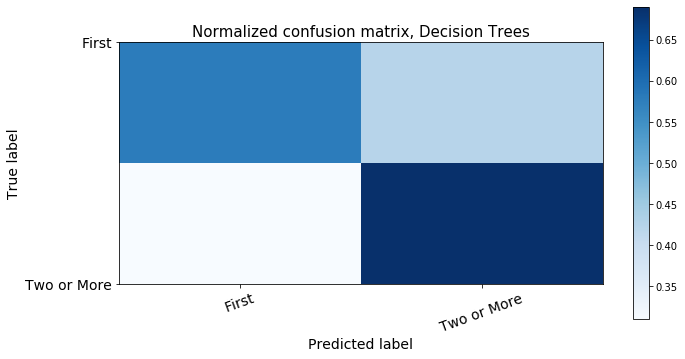

In [39]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_dec_tree))

# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': data_imputed.columns,
                    'importances': dec_tree_model.feature_importances_}).sort_values(['importances'], ascending = 0))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_dec_tree = confusion_matrix(y_validation, valid_predict_dec_tree)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_dec_tree, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Decision Trees')

In [18]:
#tree.plot_tree(dec_tree_model)

[Text(190.95460497922724, 214.85142857142856, 'X[18] <= 4.5\ngini = 0.48\nsamples = 112000\nvalue = [44924, 67076]'),
 Text(89.25877296469542, 209.6742857142857, 'X[3] <= 0.5\ngini = 0.391\nsamples = 56118\nvalue = [14947, 41171]'),
 Text(40.136151047453104, 204.49714285714285, 'X[61] <= 0.5\ngini = 0.441\nsamples = 36688\nvalue = [12061, 24627]'),
 Text(13.143818945559952, 199.32, 'X[21] <= 4.5\ngini = 0.331\nsamples = 11623\nvalue = [2434, 9189]'),
 Text(5.978828443660551, 194.14285714285714, 'X[50] <= 0.5\ngini = 0.409\nsamples = 2840\nvalue = [813, 2027]'),
 Text(3.4023909885973707, 188.96571428571428, 'X[20] <= 1.5\ngini = 0.383\nsamples = 2267\nvalue = [585, 1682]'),
 Text(2.1607254336037496, 183.78857142857143, 'X[29] <= 4.5\ngini = 0.442\nsamples = 782\nvalue = [258, 524]'),
 Text(1.757673613678379, 178.61142857142858, 'X[2] <= 0.5\ngini = 0.436\nsamples = 746\nvalue = [240, 506]'),
 Text(1.3668054026586316, 173.43428571428572, 'X[69] <= 0.5\ngini = 0.42\nsamples = 591\nvalue =

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd2cb3d2ef0> (for post_execute):


KeyboardInterrupt: 

KeyError: (220.01047555443037, 137.1942857142857, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]', 'black', 'center', 'center', 2304567369688432363, None, None, 72.0, <weakref at 0x7fd287399dd0; to 'RendererAgg' at 0x7fd28aac2650>, 1.2)

<Figure size 432x288 with 1 Axes>

In [40]:
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model = GradientBoostingClassifier(random_state=75)
gbt_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_gbt = gbt_model.predict(x_validation)

              precision    recall  f1-score   support

           0       0.70      0.53      0.60     19253
           1       0.73      0.85      0.78     28747

    accuracy                           0.72     48000
   macro avg       0.71      0.69      0.69     48000
weighted avg       0.72      0.72      0.71     48000


Normalized confusion matrix



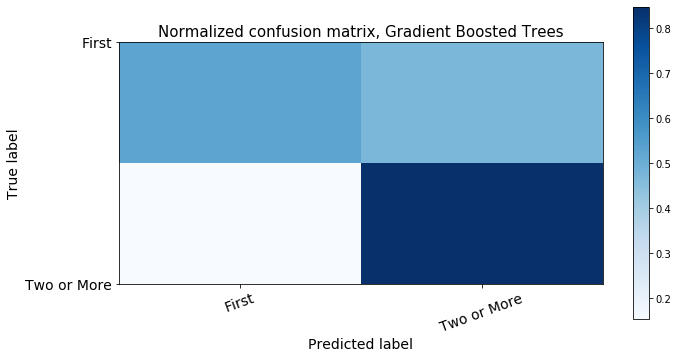

In [41]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_gbt))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [42]:
print(pd.DataFrame({'features': data_imputed.columns,
                    'importances': gbt_model.feature_importances_}).sort_values(['importances'], ascending = 0).iloc[0:30,:])


                                  features  importances
53                        division_Pacific     0.244421
3                                   HERFLG     0.087691
54                 division_South_Atlantic     0.078966
19                               age_group     0.074557
25                                 psyprob     0.057577
59                     services_Ambulatory     0.054035
18                                 NUMSUBS     0.052786
57             division_West_South_Central     0.029780
52                    division_New_England     0.029768
22                                    educ     0.026942
41  psource_Alcohol_Drug_Care_Professional     0.026300
49             division_East_South_Central     0.025494
24                                 arrests     0.024033
27                                 frstuse     0.020714
1                                  COKEFLG     0.020695
56             division_West_North_Central     0.019796
50                   division_Mid_Atlantic     0

In [43]:
rf_model = RandomForestClassifier(random_state=75)
rf_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_rf = rf_model.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.62      0.62      0.62     19253
           1       0.75      0.75      0.75     28747

    accuracy                           0.70     48000
   macro avg       0.68      0.68      0.68     48000
weighted avg       0.70      0.70      0.70     48000

            features  importances
19         age_group     0.104659
27           frstuse     0.078973
22              educ     0.064572
28          freq_use     0.045685
53  division_Pacific     0.030392
..               ...          ...
12           BARBFLG     0.000226
14            INHFLG     0.000223
11           TRNQFLG     0.000159
58          ethnic_1     0.000000
26           numsubs     0.000000

[73 rows x 2 columns]

Normalized confusion matrix



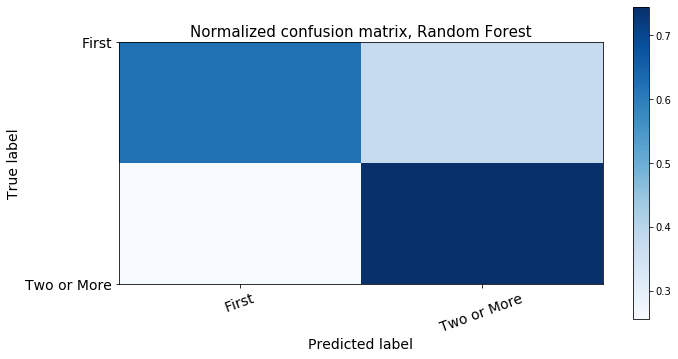

In [44]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_rf))

# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': data_imputed.columns,
                    'importances': rf_model.feature_importances_}).sort_values(['importances'], ascending = 0))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, 
                      normalize=True,title='Normalized confusion matrix, Random Forest')

In [46]:
# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': data_imputed.columns,
                    'importances': rf_model.feature_importances_}).sort_values(['importances'], ascending = 0).iloc[0:45,:])

                                  features  importances
19                               age_group     0.104659
27                                 frstuse     0.078973
22                                    educ     0.064572
28                                freq_use     0.045685
53                        division_Pacific     0.030392
20                                  gender     0.027893
18                                 NUMSUBS     0.027237
25                                 psyprob     0.024935
24                                 arrests     0.020334
64                   marstat_Never_Married     0.020084
47                   psource_Self_referral     0.019171
69                       employ_Unemployed     0.018588
40                              race_White     0.018386
72              livarag_Independent_Living     0.018230
3                                   HERFLG     0.017597
43                  psource_Court_Referral     0.017265
67               employ_Not_in_labor_force     0

In [12]:
# Create a medium-sized data set with all variables above 0.005 in importance
x_train_sm = x_train[:, [19,27,22,28,53,49,20,18,25,24,64,57,47,69,40,72,3,43,67,50,59,1,32,54,52,36,2,66,30,70,42,21,62,31,7,56,29,63,48,4,17,71,45,41]]
x_validation_sm = x_validation[:, [19,27,22,28,53,49,20,18,25,24,64,57,47,69,40,72,3,43,67,50,59,1,32,54,52,36,2,66,30,70,42,21,62,31,7,56,29,63,48,4,17,71,45,41]]
x_test_sm = x_test[:, [19,27,22,28,53,49,20,18,25,24,64,57,47,69,40,72,3,43,67,50,59,1,32,54,52,36,2,66,30,70,42,21,62,31,7,56,29,63,48,4,17,71,45,41]]
features_sm = data_imputed.iloc[:, [19,27,22,28,53,49,20,18,25,24,64,57,47,69,40,72,3,43,67,50,59,1,32,54,52,36,2,66,30,70,42,21,62,31,7,56,29,63,48,4,17,71,45,41]]

In [48]:
dec_tree_model_sm = DecisionTreeClassifier(random_state=75)
dec_tree_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_dec_tree_sm = dec_tree_model_sm.predict(x_validation_sm)

              precision    recall  f1-score   support

           0       0.55      0.58      0.57     19253
           1       0.71      0.68      0.70     28747

    accuracy                           0.64     48000
   macro avg       0.63      0.63      0.63     48000
weighted avg       0.65      0.64      0.64     48000

                                  features  importances
0                                age_group     0.101081
2                                     educ     0.077807
1                                  frstuse     0.075181
4                         division_Pacific     0.060163
3                                 freq_use     0.048696
7                                  NUMSUBS     0.032708
16                                  HERFLG     0.031660
6                                   gender     0.028931
23                 division_South_Atlantic     0.025713
9                                  arrests     0.025256
14                              race_White     0.024891
1

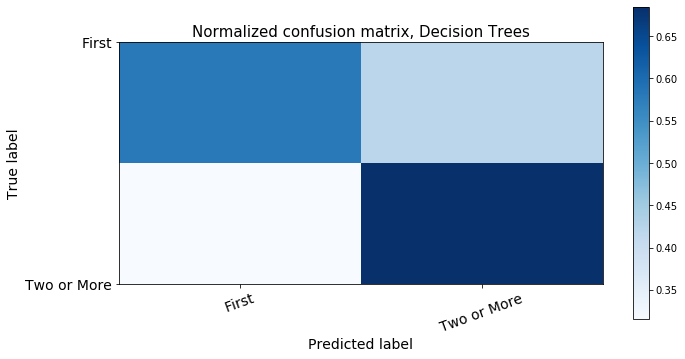

In [49]:
# Evaluation metrics and feature importances to narrow down variables I need
print(classification_report(y_validation, valid_predict_dec_tree_sm))

# Print feature importances to subset data set to more important variables
print(pd.DataFrame({'features': features_sm.columns,
                    'importances': dec_tree_model_sm.feature_importances_}).sort_values(['importances'], ascending = 0))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_dec_tree_sm = confusion_matrix(y_validation, valid_predict_dec_tree_sm)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_dec_tree_sm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Decision Trees')

In [50]:
# Gradient boosted trees, varying the maximum depth of the tree
max_depth = [5, 7, 9, 15, 20]

results_dctree_max_depth = pd.DataFrame([])

for i in range(0,5):
    
    print(i)
    
    max_depth_value = max_depth[i]
    
    dctree_model = DecisionTreeClassifier(random_state = 75, max_depth = max_depth_value)

    dctree_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_dctree = dctree_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_dctree, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_dctree, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = max_depth_value
    class_report.loc[:, 'model'] = 'Decision Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_dctree_max_depth = pd.concat([results_dctree_max_depth, class_report], axis = 0)
    
# Results: Accuracy increased with the depth of the tree, but did not increase enough from 7 to 9 to justify extra processing time

0
1
2
3
4


In [51]:
results_dctree_max_depth

,precision,recall,f1-score,support,accuracy,max_depth,model,model_value
0,0.698679,0.414896,0.520628,19253.0,0.693542,5,Decision Trees,First Treatment Episode
1,0.691935,0.880161,0.774780,28747.0,0.693542,5,Decision Trees,2+ Treatment Episodes
0,0.712403,0.437958,0.542443,19253.0,0.703646,7,Decision Trees,First Treatment Episode
1,0.700780,0.881588,0.780854,28747.0,0.703646,7,Decision Trees,2+ Treatment Episodes
0,0.705864,0.467667,0.562592,19253.0,0.708313,9,Decision Trees,First Treatment Episode
1,0.709199,0.869482,0.781204,28747.0,0.708313,9,Decision Trees,2+ Treatment Episodes
0,0.648931,0.567600,0.605547,19253.0,0.703396,15,Decision Trees,First Treatment Episode
1,0.732831,0.794344,0.762348,28747.0,0.703396,15,Decision Trees,2+ Treatment Episodes
0,0.599735,0.564068,0.581355,19253.0,0.674146,20,Decision Trees,First Treatment Episode
1,0.719223,0.747869,0.733266,28747.0,0.674146,20,Decision Trees,2+ Treatment Episodes


In [57]:
# Gradient boosted trees, varying the maximum depth of the tree
min_samples_split = [2, 4, 7, 15, 30, 40, 50]

results_dctree_min_samples = pd.DataFrame([])

for i in range(0,7):
    
    print(i)
    
    min_samples_split_value = min_samples_split[i]
    
    dctree_model = DecisionTreeClassifier(random_state = 75, min_samples_split = min_samples_split_value)

    dctree_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_dctree = dctree_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_dctree, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_dctree, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_samples_split'] = min_samples_split_value
    class_report.loc[:, 'model'] = 'Decision Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_dctree_min_samples = pd.concat([results_dctree_min_samples, class_report], axis = 0)
    

0
1
2
3
4
5
6


In [58]:
results_dctree_min_samples

,precision,recall,f1-score,support,accuracy,min_samples_split,model,model_value
0,0.552055,0.579754,0.565565,19253.0,0.642750,2,Decision Trees,First Treatment Episode
1,0.708758,0.684941,0.696646,28747.0,0.642750,2,Decision Trees,2+ Treatment Episodes
0,0.548367,0.594764,0.570624,19253.0,0.640979,4,Decision Trees,First Treatment Episode
1,0.712294,0.671931,0.691524,28747.0,0.640979,4,Decision Trees,2+ Treatment Episodes
0,0.555349,0.604529,0.578896,19253.0,0.647229,7,Decision Trees,First Treatment Episode
1,0.718438,0.675827,0.696481,28747.0,0.647229,7,Decision Trees,2+ Treatment Episodes
0,0.574215,0.597777,0.585759,19253.0,0.660875,15,Decision Trees,First Treatment Episode
1,0.723003,0.703134,0.712930,28747.0,0.660875,15,Decision Trees,2+ Treatment Episodes
0,0.606416,0.600841,0.603616,19253.0,0.683479,30,Decision Trees,First Treatment Episode
1,0.734304,0.738825,0.736557,28747.0,0.683479,30,Decision Trees,2+ Treatment Episodes


In [59]:
# Gradient boosted trees, varying the maximum depth of the tree
max_features = [5, 7, 9, 12, 15, 20]

results_dctree_max_feat = pd.DataFrame([])

for i in range(0,6):
    
    print(i)
    
    max_feat_value = max_features[i]
    
    dctree_model = DecisionTreeClassifier(random_state = 75, max_features = max_feat_value)

    dctree_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_dctree = dctree_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_dctree, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_dctree, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_features'] = max_feat_value
    class_report.loc[:, 'model'] = 'Decision Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_dctree_max_feat = pd.concat([results_dctree_max_feat, class_report], axis = 0)
    

0
1
2
3
4
5


In [60]:
results_dctree_max_feat

,precision,recall,f1-score,support,accuracy,max_features,model,model_value
0,0.556355,0.566353,0.561310,19253.0,0.644917,5,Decision Trees,First Treatment Episode
1,0.706031,0.697534,0.701757,28747.0,0.644917,5,Decision Trees,2+ Treatment Episodes
0,0.556396,0.573417,0.564778,19253.0,0.645521,7,Decision Trees,First Treatment Episode
1,0.708324,0.693812,0.700993,28747.0,0.645521,7,Decision Trees,2+ Treatment Episodes
0,0.555081,0.573677,0.564226,19253.0,0.644563,9,Decision Trees,First Treatment Episode
1,0.707921,0.692037,0.699889,28747.0,0.644563,9,Decision Trees,2+ Treatment Episodes
0,0.558014,0.576274,0.566997,19253.0,0.646958,12,Decision Trees,First Treatment Episode
1,0.709855,0.694299,0.701991,28747.0,0.646958,12,Decision Trees,2+ Treatment Episodes
0,0.557758,0.577313,0.567367,19253.0,0.646854,15,Decision Trees,First Treatment Episode
1,0.710103,0.693429,0.701667,28747.0,0.646854,15,Decision Trees,2+ Treatment Episodes


In [61]:
# Compare accuracy of default model with medium and large data frames
# Run default gradient boosted trees model to get baseline accuracy and feature importances
gbt_model_sm = GradientBoostingClassifier(random_state=75)
gbt_model_sm.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt_sm = gbt_model_sm.predict(x_validation_sm)

              precision    recall  f1-score   support

           0       0.70      0.53      0.61     19253
           1       0.73      0.85      0.78     28747

    accuracy                           0.72     48000
   macro avg       0.72      0.69      0.69     48000
weighted avg       0.72      0.72      0.71     48000


Normalized confusion matrix



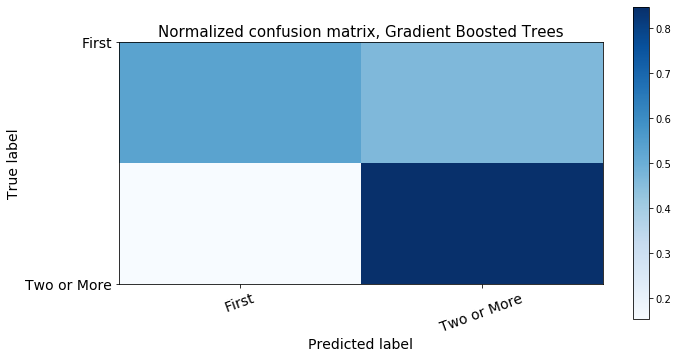

In [62]:
# Evaluation metrics are the same as with the full data set so stick with the limited data set
print(classification_report(y_validation, valid_predict_gbt_sm))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt_sm = confusion_matrix(y_validation, valid_predict_gbt_sm)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt_sm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

# Results: Accuracy increased to 70%, but first treatment episode accuracy did not change

In [66]:
# Gradient boosted trees, grid search varying the number of estimators
n_estimators = [50, 100, 150, 200, 300]

results_gbt_nEst = pd.DataFrame([])

for i in range(0,5):
    
    print(i)
    
    est_value = n_estimators[i]

    gbt_model = GradientBoostingClassifier(random_state = 75, n_estimators = est_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = est_value
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_nEst = pd.concat([results_gbt_nEst, class_report], axis = 0)
    
# Results: Accuracy increased with the number of estimators, but 200 and 300 were not different enough to justify the extra processing time

0
1
2
3
4


In [67]:
results_gbt_nEst
# Minimal increase in accuracy when greater than 100 so will stick with 150 for further testing

,precision,recall,f1-score,support,accuracy,n_estimators,model,model_value
0,0.715457,0.476030,0.571687,19253.0,0.713896,50,Gradient Boosted Trees,First Treatment Episode
1,0.713328,0.873204,0.785210,28747.0,0.713896,50,Gradient Boosted Trees,2+ Treatment Episodes
0,0.700573,0.533008,0.605410,19253.0,0.721313,100,Gradient Boosted Trees,First Treatment Episode
1,0.730421,0.847428,0.784586,28747.0,0.721313,100,Gradient Boosted Trees,2+ Treatment Episodes
0,0.695015,0.546720,0.612012,19253.0,0.721958,150,Gradient Boosted Trees,First Treatment Episode
1,0.734378,0.839322,0.783351,28747.0,0.721958,150,Gradient Boosted Trees,2+ Treatment Episodes
0,0.695406,0.554251,0.616856,19253.0,0.723833,200,Gradient Boosted Trees,First Treatment Episode
1,0.737192,0.837409,0.784111,28747.0,0.723833,200,Gradient Boosted Trees,2+ Treatment Episodes
0,0.695624,0.558978,0.619859,19253.0,0.725000,300,Gradient Boosted Trees,First Treatment Episode
1,0.738971,0.836192,0.784581,28747.0,0.725000,300,Gradient Boosted Trees,2+ Treatment Episodes


In [12]:
# Gradient boosted trees, varying the maximum depth of the tree
max_depth = [5, 7, 9, 15]

results_gbt_max_depth = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    max_depth_value = max_depth[i]
    
    gbt_model = GradientBoostingClassifier(random_state = 75, n_estimators = 100, max_depth = max_depth_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = max_depth_value
    class_report.loc[:, 'n_estimators'] = 100
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_max_depth = pd.concat([results_gbt_max_depth, class_report], axis = 0)
    
# Results: Accuracy increased with the depth of the tree, but did not increase enough from 7 to 9 to justify extra processing time

0
1
2
3


In [13]:
results_gbt_max_depth

,precision,recall,f1-score,support,accuracy,max_depth,n_estimators,model,model_value
0,0.698539,0.556277,0.619344,19253.0,0.725729,5,100,Gradient Boosted Trees,First Treatment Episode
1,0.738490,0.839218,0.785639,28747.0,0.725729,5,100,Gradient Boosted Trees,2+ Treatment Episodes
0,0.699758,0.569677,0.628053,19253.0,0.729354,7,100,Gradient Boosted Trees,First Treatment Episode
1,0.743705,0.836296,0.787287,28747.0,0.729354,7,100,Gradient Boosted Trees,2+ Treatment Episodes
0,0.695545,0.583805,0.634795,19253.0,0.730563,9,100,Gradient Boosted Trees,First Treatment Episode
1,0.748335,0.828852,0.786538,28747.0,0.730563,9,100,Gradient Boosted Trees,2+ Treatment Episodes
0,0.664823,0.580637,0.619885,19253.0,0.714375,15,100,Gradient Boosted Trees,First Treatment Episode
1,0.741093,0.803945,0.771241,28747.0,0.714375,15,100,Gradient Boosted Trees,2+ Treatment Episodes


In [14]:
# Gradient boosted trees, grid search varying the learning rate
# Going to compare the results of this to the results from n_estimators because these hyperparameters present a trade off
learning_rate = [0.05, 0.15, 0.3, 0.35]

results_gbt_learn_rate = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    learn_rate_value = learning_rate[i]

    gbt_model = GradientBoostingClassifier(random_state = 75, learning_rate = learn_rate_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'learning_rate'] = learn_rate_value
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_learn_rate = pd.concat([results_gbt_learn_rate, class_report], axis = 0)

# Results: Accuracy optimal with a learning rate of 0.3, results more accurate than with n_estimators altered

0
1
2
3


In [15]:
results_gbt_learn_rate

,precision,recall,f1-score,support,accuracy,learning_rate,model,model_value
0,0.715799,0.473692,0.570107,19253.0,0.713458,0.05,Gradient Boosted Trees,First Treatment Episode
1,0.712612,0.874039,0.785114,28747.0,0.713458,0.05,Gradient Boosted Trees,2+ Treatment Episodes
0,0.695045,0.547863,0.612739,19253.0,0.722229,0.15,Gradient Boosted Trees,First Treatment Episode
1,0.734798,0.839009,0.783453,28747.0,0.722229,0.15,Gradient Boosted Trees,2+ Treatment Episodes
0,0.693630,0.561627,0.620688,19253.0,0.724667,0.30,Gradient Boosted Trees,First Treatment Episode
1,0.739595,0.833861,0.783904,28747.0,0.724667,0.30,Gradient Boosted Trees,2+ Treatment Episodes
0,0.694369,0.569366,0.625685,19253.0,0.726750,0.35,Gradient Boosted Trees,First Treatment Episode
1,0.742619,0.832156,0.784843,28747.0,0.726750,0.35,Gradient Boosted Trees,2+ Treatment Episodes


In [16]:
# Gradient boosted trees, grid search varying learning rate and maximum depth of trees
learning_rate = [0.05, 0.15, 0.3]
max_depth = [5, 7, 9]

results_gbt_lrate_depth = pd.DataFrame([])

for i, j in itertools.product(range(0,3), range(0,3)):
    
    print(i)
    print(j)
    
    max_depth_value = max_depth[i]
    
    learning_rate_value = learning_rate[j]

    gbt_model = GradientBoostingClassifier(random_state = 75, max_depth = max_depth_value,
                                           learning_rate = learning_rate_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = max_depth_value
    class_report.loc[:, 'learning_rate'] = learning_rate_value
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_lrate_depth = pd.concat([results_gbt_lrate_depth, class_report], axis = 0)

# Results: Optimal results with max_depth = 7 and learning_rate = 0.3
# Accuracy = 0.72, F1-score for 1st treatment: 0.54, F1-score for 2+ treatments: 0.80

0
0
0
1
0
2
1
0
1
1
1
2
2
0
2
1
2
2


In [17]:
results_gbt_lrate_depth

,precision,recall,f1-score,support,accuracy,max_depth,learning_rate,model,model_value
0,0.708898,0.530099,0.606597,19253.0,0.724208,5,0.05,Gradient Boosted Trees,First Treatment Episode
1,0.730768,0.854211,0.787682,28747.0,0.724208,5,0.05,Gradient Boosted Trees,2+ Treatment Episodes
0,0.698916,0.566197,0.625595,19253.0,0.728167,5,0.15,Gradient Boosted Trees,First Treatment Episode
1,0.742246,0.836644,0.786623,28747.0,0.728167,5,0.15,Gradient Boosted Trees,2+ Treatment Episodes
0,0.697163,0.574300,0.629795,19253.0,0.729187,5,0.30,Gradient Boosted Trees,First Treatment Episode
1,0.744991,0.832922,0.786506,28747.0,0.729187,5,0.30,Gradient Boosted Trees,2+ Treatment Episodes
0,0.705596,0.550096,0.618218,19253.0,0.727479,7,0.05,Gradient Boosted Trees,First Treatment Episode
1,0.737436,0.846280,0.788117,28747.0,0.727479,7,0.05,Gradient Boosted Trees,2+ Treatment Episodes
0,0.696609,0.580429,0.633234,19253.0,0.730313,7,0.15,Gradient Boosted Trees,First Treatment Episode
1,0.747231,0.830695,0.786756,28747.0,0.730313,7,0.15,Gradient Boosted Trees,2+ Treatment Episodes


In [18]:
# Gradient boosted trees, attempting early stopping with minimum impurity decrease
min_imp_dec = [0.25, 0.5, 0.1]

results_gbt_imp_dec = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    min_imp_value = min_imp_dec[i]

    gbt_model = GradientBoostingClassifier(random_state = 75, learning_rate = 0.3, 
                                           min_impurity_decrease = min_imp_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_impurity_decrease'] = min_imp_value
    class_report.loc[:, 'learning_rate'] = 0.3
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_imp_dec = pd.concat([results_gbt_imp_dec, class_report], axis = 0)

# Results: Accuracy decreased by several points on average

0
1
2


In [19]:
results_gbt_imp_dec

,precision,recall,f1-score,support,accuracy,min_impurity_decrease,learning_rate,model,model_value
0,0.694932,0.561886,0.621367,19253.0,0.725333,0.25,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.739925,0.834800,0.784505,28747.0,0.725333,0.25,0.3,Gradient Boosted Trees,2+ Treatment Episodes
0,0.693369,0.558355,0.618580,19253.0,0.723812,0.50,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.738337,0.834626,0.783534,28747.0,0.723812,0.50,0.3,Gradient Boosted Trees,2+ Treatment Episodes
0,0.694725,0.563704,0.622394,19253.0,0.725646,0.10,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.740565,0.834104,0.784556,28747.0,0.725646,0.10,0.3,Gradient Boosted Trees,2+ Treatment Episodes


In [13]:
# Gradient boosted trees, grid search varying maximum depth and max_features
max_depth = [5, 7, 9]
max_features = [7, 10, 15]

results_gbt_feat_maxdepth = pd.DataFrame([])

for i, j in itertools.product(range(0,3), range(0,3)):
    
    max_depth_value = max_depth[i]
    
    max_feat_value = max_features[j]

    gbt_model = GradientBoostingClassifier(random_state = 75, max_depth = max_depth_value,
                                           learning_rate = 0.3, max_features = max_feat_value)

    gbt_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_gbt = gbt_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'max_depth'] = max_depth_value
    class_report.loc[:, 'max_features'] = max_feat_value
    class_report.loc[:, 'learning_rate'] = 0.3
    class_report.loc[:, 'model'] = 'Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_gbt_feat_maxdepth = pd.concat([results_gbt_feat_maxdepth, class_report], axis = 0)

# Results: Adding a maximum feature parameter changed the model metrics very little

In [14]:
results_gbt_feat_maxdepth

,precision,recall,f1-score,support,accuracy,max_depth,max_features,learning_rate,model,model_value
0,0.695547,0.569574,0.626289,19253.0,0.727354,5,7,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.742911,0.833026,0.785392,28747.0,0.727354,5,7,0.3,Gradient Boosted Trees,2+ Treatment Episodes
0,0.694896,0.572794,0.627965,19253.0,0.727771,5,10,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.744009,0.831565,0.785354,28747.0,0.727771,5,10,0.3,Gradient Boosted Trees,2+ Treatment Episodes
0,0.695740,0.573417,0.628684,19253.0,0.728313,5,15,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.744398,0.832052,0.785788,28747.0,0.728313,5,15,0.3,Gradient Boosted Trees,2+ Treatment Episodes
0,0.688571,0.584532,0.632300,19253.0,0.727313,7,7,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.747315,0.822938,0.783305,28747.0,0.727313,7,7,0.3,Gradient Boosted Trees,2+ Treatment Episodes
0,0.688804,0.582870,0.631425,19253.0,0.727062,7,10,0.3,Gradient Boosted Trees,First Treatment Episode
1,0.746720,0.823634,0.783293,28747.0,0.727062,7,10,0.3,Gradient Boosted Trees,2+ Treatment Episodes


In [15]:
# Stochastic Gradient Boosted Trees, grid search with varying sub-samples
sub_sample = [0.8, 0.9, 0.95]

results_stoch_grad = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    subsample_value = sub_sample[i]

    stoch_grad_model = GradientBoostingClassifier(random_state = 75, subsample = subsample_value)

    stoch_grad_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_stoch_grad = stoch_grad_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_stoch_grad, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_gbt, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'subsample'] = subsample_value
    class_report.loc[:, 'learning_rate'] = 0.3
    class_report.loc[:, 'max_depth'] = 9
    class_report.loc[:, 'model'] = 'Stochastic Gradient Boosted Trees'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_stoch_grad = pd.concat([results_stoch_grad, class_report], axis = 0)

# Results: Adding a sub-sampling parameter changed the model metrics very little

0
1
2


In [24]:
results_stoch_grad

,precision,recall,f1-score,support,accuracy,subsample,learning_rate,max_depth,model,model_value
0,0.659499,0.583078,0.618939,19253.0,0.598896,0.80,0.3,9,Stochastic Gradient Boosted Trees,First Treatment Episode
1,0.740881,0.798379,0.768556,28747.0,0.598896,0.80,0.3,9,Stochastic Gradient Boosted Trees,2+ Treatment Episodes
0,0.661060,0.587856,0.622313,19253.0,0.598896,0.90,0.3,9,Stochastic Gradient Boosted Trees,First Treatment Episode
1,0.743029,0.798135,0.769597,28747.0,0.598896,0.90,0.3,9,Stochastic Gradient Boosted Trees,2+ Treatment Episodes
0,0.667020,0.588480,0.625293,19253.0,0.598896,0.95,0.3,9,Stochastic Gradient Boosted Trees,First Treatment Episode
1,0.744535,0.803249,0.772778,28747.0,0.598896,0.95,0.3,9,Stochastic Gradient Boosted Trees,2+ Treatment Episodes


In [25]:
# Running a default random forest model
rf_model_default = RandomForestClassifier(random_state=75)
rf_model_default.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf_def = rf_model_default.predict(x_validation_sm)

# Results: Accuracy is 69% with F1-score of 52% for first treatment and 77% for 2+ treatments

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.62      0.62      0.62     19253
           1       0.74      0.75      0.75     28747

    accuracy                           0.69     48000
   macro avg       0.68      0.68      0.68     48000
weighted avg       0.69      0.69      0.69     48000


Normalized confusion matrix



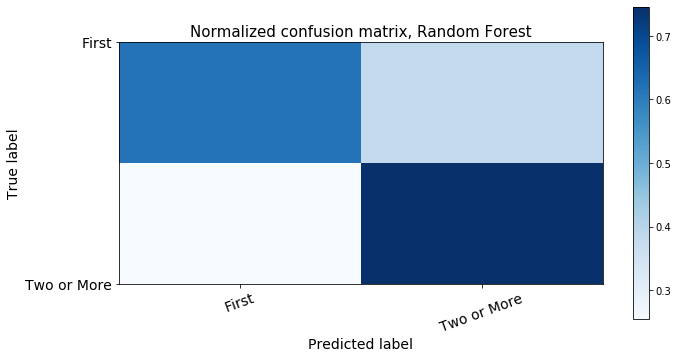

In [26]:
# Print classification report
print(classification_report(y_validation, valid_predict_rf_def))

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf_def = confusion_matrix(y_validation, valid_predict_rf_def)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf_def, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [27]:
# Random Forest, grid search varying the number of estimators
n_estimators = [200, 300, 350]

results_rf_n_est = pd.DataFrame([])

for i in range(0,3):
    
    print(i)
    
    n_est_value = n_estimators[i]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = n_est_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = n_est_value
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_n_est = pd.concat([results_rf_n_est, class_report], axis = 0)

# Results: An increase in accuracy until 300, enough to warrant keeping 300 over 200 although similar

0
1
2


In [28]:
results_rf_n_est

,precision,recall,f1-score,support,accuracy,n_estimators,model,model_value
0,0.686223,0.568639,0.621922,19253.0,0.722688,200,Random Forest,First Treatment Episode
1,0.740841,0.825860,0.781044,28747.0,0.722688,200,Random Forest,2+ Treatment Episodes
0,0.687437,0.567860,0.621953,19253.0,0.723104,300,Random Forest,First Treatment Episode
1,0.740778,0.827078,0.781553,28747.0,0.723104,300,Random Forest,2+ Treatment Episodes
0,0.688745,0.567652,0.622363,19253.0,0.723688,350,Random Forest,First Treatment Episode
1,0.740944,0.828191,0.782142,28747.0,0.723688,350,Random Forest,2+ Treatment Episodes


In [33]:
# Random Forest, grid search varying the minimum samples per split
min_samples_split = [5, 9, 12, 18, 25]

results_rf_min_samp = pd.DataFrame([])

for i in range(0,5):
    
    print(i)
    
    min_samp_split_value = min_samples_split[i]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     min_samples_split = min_samp_split_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_samples_split'] = min_samp_split_value
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_min_samp = pd.concat([results_rf_min_samp, class_report], axis = 0)
    
# Results: Accuracy optimized at min_samples_split = 9

0
1
2
3
4


In [34]:
results_rf_min_samp

,precision,recall,f1-score,support,accuracy,min_samples_split,n_estimators,model,model_value
0,0.702132,0.564535,0.625860,19253.0,0.729271,5,300,Random Forest,First Treatment Episode
1,0.742189,0.839601,0.787896,28747.0,0.729271,5,300,Random Forest,2+ Treatment Episodes
0,0.706839,0.557783,0.623527,19253.0,0.729833,9,300,Random Forest,First Treatment Episode
1,0.740482,0.845062,0.789323,28747.0,0.729833,9,300,Random Forest,2+ Treatment Episodes
0,0.709906,0.555706,0.623412,19253.0,0.730708,12,300,Random Forest,First Treatment Episode
1,0.740229,0.847915,0.790421,28747.0,0.730708,12,300,Random Forest,2+ Treatment Episodes
0,0.712374,0.550200,0.620872,19253.0,0.730479,18,300,Random Forest,First Treatment Episode
1,0.738605,0.851219,0.790924,28747.0,0.730479,18,300,Random Forest,2+ Treatment Episodes
0,0.716063,0.547136,0.620304,19253.0,0.731333,25,300,Random Forest,First Treatment Episode
1,0.738082,0.854698,0.792121,28747.0,0.731333,25,300,Random Forest,2+ Treatment Episodes


In [18]:
# Random Forest, testing early stopping with a grid search on minimum impurity decrease per split
min_impurity_decrease = [0.0005, 0.001, 0.002, 0.003]

results_rf_imp_dec = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    min_imp_dec_value = min_impurity_decrease[i]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     min_impurity_decrease = min_imp_dec_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'min_impurity_decrease'] = min_imp_dec_value
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_imp_dec = pd.concat([results_rf_imp_dec, class_report], axis = 0)

# Results: Accuracy dropped a large amount to mid-60%s

0
1
2
3


In [19]:
results_rf_imp_dec

,precision,recall,f1-score,support,accuracy,min_impurity_decrease,n_estimators,model,model_value
0,0.734220,0.387264,0.507073,19253.0,0.698000,0.0005,300,Random Forest,First Treatment Episode
1,0.688281,0.906112,0.782316,28747.0,0.698000,0.0005,300,Random Forest,2+ Treatment Episodes
0,0.743971,0.350906,0.476883,19253.0,0.691208,0.0010,300,Random Forest,First Treatment Episode
1,0.678897,0.919122,0.780954,28747.0,0.691208,0.0010,300,Random Forest,2+ Treatment Episodes
0,0.757226,0.310237,0.440146,19253.0,0.683438,0.0020,300,Random Forest,First Treatment Episode
1,0.668927,0.933384,0.779332,28747.0,0.683438,0.0020,300,Random Forest,2+ Treatment Episodes
0,0.821872,0.202981,0.325558,19253.0,0.662667,0.0030,300,Random Forest,First Treatment Episode
1,0.645161,0.970536,0.775086,28747.0,0.662667,0.0030,300,Random Forest,2+ Treatment Episodes


In [35]:
# Random Forest, grid search varying the maximum features and minimum samples per split
max_features = [7, 10, 15]
min_samples_split = [9, 12]

results_rf_feat_samp_split = pd.DataFrame([])

for i, j in itertools.product(range(0,3), range(0,2)):
    
    print(i)
    print(j)
    
    max_feat_value = max_features[i]
    min_samp_split_value = min_samples_split[j]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     max_features = max_feat_value, min_samples_split = min_samp_split_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'max_features'] = max_feat_value
    class_report.loc[:, 'min_samples_split'] = min_samp_split_value
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_feat_samp_split = pd.concat([results_rf_feat_samp_split, class_report], axis = 0)

# Results: The above changes attempted did not increase accuracy above the other models

0
0
0
1
1
0
1
1
2
0
2
1


In [36]:
results_rf_feat_samp_split

,precision,recall,f1-score,support,accuracy,n_estimators,max_features,min_samples_split,model,model_value
0,0.704529,0.561523,0.624949,19253.0,0.729667,300,7,9,Random Forest,First Treatment Episode
1,0.741479,0.842279,0.788671,28747.0,0.729667,300,7,9,Random Forest,2+ Treatment Episodes
0,0.709030,0.559549,0.625483,19253.0,0.731229,300,7,12,Random Forest,First Treatment Episode
1,0.741511,0.846210,0.790408,28747.0,0.731229,300,7,12,Random Forest,2+ Treatment Episodes
0,0.700032,0.566665,0.626328,19253.0,0.728792,300,10,9,Random Forest,First Treatment Episode
1,0.742619,0.837374,0.787155,28747.0,0.728792,300,10,9,Random Forest,2+ Treatment Episodes
0,0.704778,0.565418,0.627453,19253.0,0.730688,300,10,12,Random Forest,First Treatment Episode
1,0.742981,0.841375,0.789123,28747.0,0.730688,300,10,12,Random Forest,2+ Treatment Episodes
0,0.697863,0.571651,0.628483,19253.0,0.728917,300,15,9,Random Forest,First Treatment Episode
1,0.744112,0.834244,0.786605,28747.0,0.728917,300,15,9,Random Forest,2+ Treatment Episodes


In [37]:
# Random Forest, varying the penalty/weight put on wrong answers for 0, which is more commonly misclassified
# Also varying minimum samples per split
min_samples_split = [9, 12]
weight = [1.5, 2, 2.5, 3]

results_rf_feat_samp_split = pd.DataFrame([])

for i, j in itertools.product(range(0,2), range(0,4)):
    
    print(i)
    print(j)
    
    max_feat_value = n_estimators[i]
    weight_value = weight[j]

    rf_model = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                     class_weight = {0:weight_value}, min_samples_split = min_samp_split_value)

    rf_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_rf = rf_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_rf, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'n_estimators'] = 300
    class_report.loc[:, 'weight_zero'] = weight_value
    class_report.loc[:, 'min_samples_split'] = min_samp_split_value
    class_report.loc[:, 'model'] = 'Random Forest'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    results_rf_feat_samp_split = pd.concat([results_rf_feat_samp_split, class_report], axis = 0)

# Results: Classification of 0 values greatly improved without sacrificing much overall accuracy
# Accuracy = 0.70, F1-score for 0 = 0.62, F1-score for 1 = 0.76

0
0
0
1
0
2
0
3
1
0
1
1
1
2
1
3


In [38]:
results_rf_feat_samp_split

,precision,recall,f1-score,support,accuracy,n_estimators,weight_zero,min_samples_split,model,model_value
0,0.661638,0.651535,0.656548,19253.0,0.726583,300,1.5,12,Random Forest,First Treatment Episode
1,0.768982,0.776846,0.772894,28747.0,0.726583,300,1.5,12,Random Forest,2+ Treatment Episodes
0,0.631192,0.717447,0.671561,19253.0,0.718521,300,2.0,12,Random Forest,First Treatment Episode
1,0.791699,0.719240,0.753732,28747.0,0.718521,300,2.0,12,Random Forest,2+ Treatment Episodes
0,0.609769,0.760557,0.676867,19253.0,0.708729,300,2.5,12,Random Forest,First Treatment Episode
1,0.807805,0.674018,0.734872,28747.0,0.708729,300,2.5,12,Random Forest,2+ Treatment Episodes
0,0.592181,0.791461,0.677470,19253.0,0.697729,300,3.0,12,Random Forest,First Treatment Episode
1,0.819696,0.634953,0.715593,28747.0,0.697729,300,3.0,12,Random Forest,2+ Treatment Episodes
0,0.661638,0.651535,0.656548,19253.0,0.726583,300,1.5,12,Random Forest,First Treatment Episode
1,0.768982,0.776846,0.772894,28747.0,0.726583,300,1.5,12,Random Forest,2+ Treatment Episodes



Normalized confusion matrix



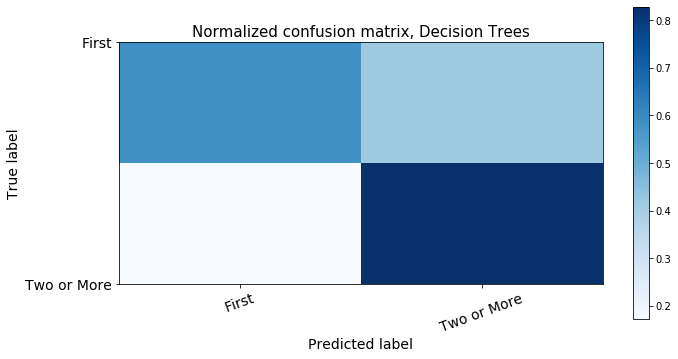

In [39]:
## Gradient Boosted Trees
dctree_model_final = GradientBoostingClassifier(random_state = 75, max_depth = 9)
dctree_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_dctree_final = dctree_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_dctree = confusion_matrix(y_validation, valid_predict_dctree_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_dctree, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Decision Trees')


Normalized confusion matrix



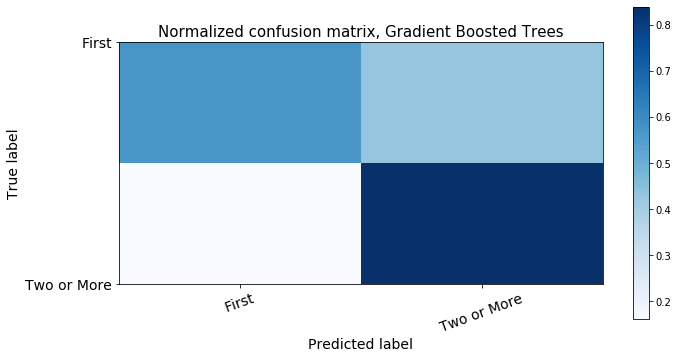

In [40]:
## Gradient Boosted Trees
gbt_model_final = GradientBoostingClassifier(random_state = 75, learning_rate = 0.05, max_depth = 9)
gbt_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_gbt_final = gbt_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_gbt = confusion_matrix(y_validation, valid_predict_gbt_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_gbt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Gradient Boosted Trees')

In [43]:
# Print classification report
print(classification_report(y_validation, valid_predict_gbt_final))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63     19253
           1       0.75      0.84      0.79     28747

    accuracy                           0.73     48000
   macro avg       0.72      0.71      0.71     48000
weighted avg       0.73      0.73      0.73     48000




Normalized confusion matrix



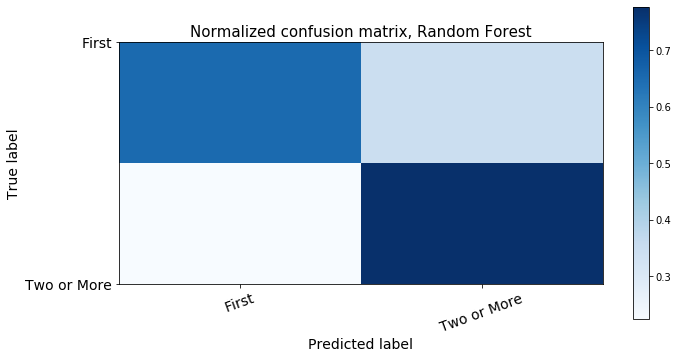

In [44]:
## Random Forest
rf_model_final = RandomForestClassifier(random_state = 75, n_jobs = 7, n_estimators = 300,
                                        class_weight = {0:1.5}, min_samples_split = 12)
rf_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_rf_final = rf_model_final.predict(x_validation_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_validation, valid_predict_rf_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

In [45]:
# Print classification report
print(classification_report(y_validation, valid_predict_rf_final))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66     19253
           1       0.77      0.78      0.77     28747

    accuracy                           0.73     48000
   macro avg       0.72      0.71      0.71     48000
weighted avg       0.73      0.73      0.73     48000



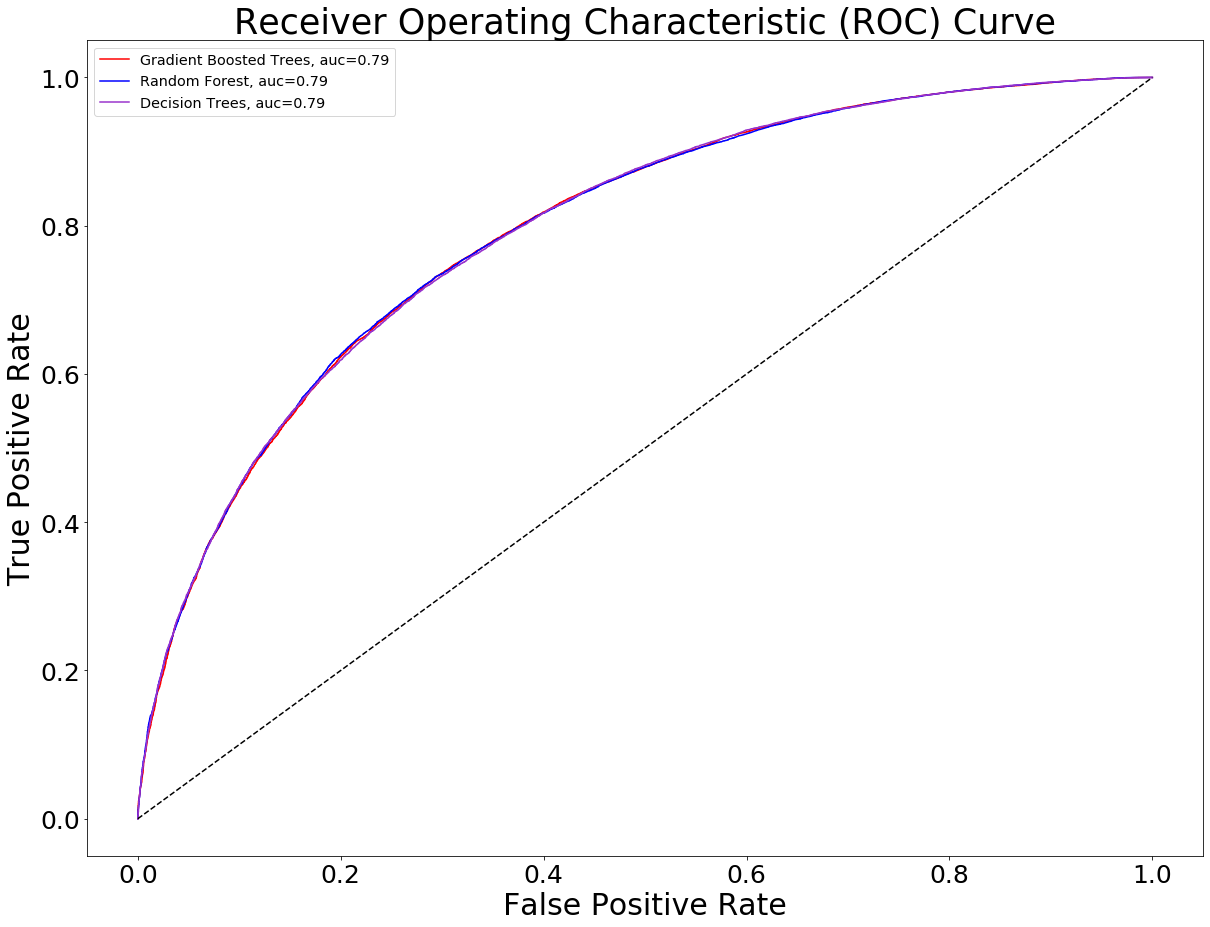

<Figure size 720x360 with 0 Axes>

In [47]:
# Building and printing ROC curves for all final models
classes = ['First', 'Two or More']

probs1 = dctree_model_final.predict_proba(x_validation_sm)
probs1 = probs1[:, 1]

probs2 = rf_model_final.predict_proba(x_validation_sm)
probs2 = probs2[:, 1]

probs3 = gbt_model_final.predict_proba(x_validation_sm)
probs3 = probs3[:, 1]

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs3)
auc = metrics.roc_auc_score(y_validation, probs3)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Gradient Boosted Trees, auc="+str(round(auc, 2)), color = 'red')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs2)
auc = metrics.roc_auc_score(y_validation, probs2)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(round(auc, 2)), color = 'blue')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs1)
auc = metrics.roc_auc_score(y_validation, probs1)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Decision Trees, auc="+str(round(auc, 2)), color = 'darkorchid')

plt.legend(loc=0, fontsize = 'x-large')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 35)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate', fontsize = 30)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.show()

plt.savefig('NumPriorTreat_ROC_Curve_Comp.png')


Normalized confusion matrix



,0,1,accuracy,macro avg,weighted avg
precision,0.703922,0.746053,0.732275,0.724987,0.729154
recall,0.573922,0.838329,0.732275,0.706125,0.732275
f1-score,0.632309,0.789504,0.732275,0.710906,0.726453
support,16044.000000,23956.000000,0.732275,40000.000000,40000.000000


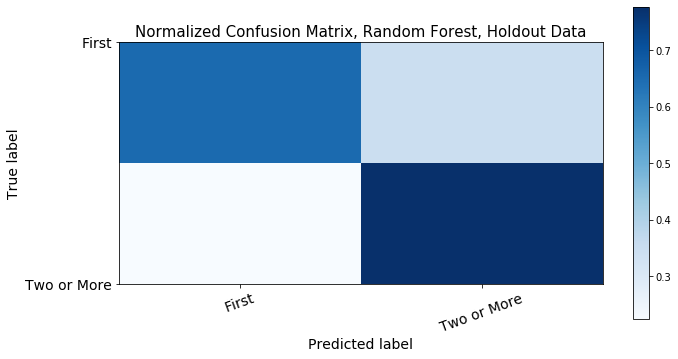

In [48]:
# Model Chosen: Random Forest with min_samples_split = 12, n_estimators = 300, and a weight of 2 on misclassifications of zero
# Above model shows lower accuracy on the ROC curve than gradient boosted trees but is the only model that classified 0s significantly higher than chance
# Testing model with final holdout data set
valid_predict_rf_ho = gbt_model_final.predict(x_test_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_rf_ho = confusion_matrix(y_test, valid_predict_rf_ho)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix, Random Forest, Holdout Data')

pd.DataFrame(classification_report(y_test, valid_predict_rf_ho, 
                                   output_dict = True))